# **Global wheat detection - EffiecntDet D7**

In [1]:
!pip install -U git+https://github.com/albu/albumentations

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-7o3es3qo
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-7o3es3qo
  Created wheel for albumentations: filename=albumentations-0.4.6-cp36-none-any.whl size=65438 sha256=d37046751ffc486e2e67b98eca5a55d1f85a693011710c3384068eafe8b07529
  Stored in directory: /tmp/pip-ephem-wheel-cache-00mmtf3l/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: albumentations 0.4.6
    Uninstalling albumentations-0.4.6:
      Successfully uninstalled albumentations-0.4.6


In [2]:
!pip install -U git+https://github.com/rwightman/efficientdet-pytorch

  Cloning https://github.com/rwightman/efficientdet-pytorch to /tmp/pip-req-build-ixdbgdgh
  Running command git clone -q https://github.com/rwightman/efficientdet-pytorch /tmp/pip-req-build-ixdbgdgh
  Created wheel for effdet: filename=effdet-0.1.4-cp36-none-any.whl size=51076 sha256=e0d29604cbff59547062e3100565a8f9e6cb1911b193d592e3050597e78810c0
  Stored in directory: /tmp/pip-ephem-wheel-cache-gjnzd3n8/wheels/b8/5f/71/526b406ac099c9cc234802355382bb3f451278c23bbcec54a4
Successfully built effdet
  Found existing installation: effdet 0.1.4
    Uninstalling effdet-0.1.4:
      Successfully uninstalled effdet-0.1.4


In [3]:
!pip install ensemble-boxes

In [4]:
!pip install timm

In [5]:
!pip install pycocotools

In [6]:
!pip install omegaconf

In [7]:
!nvidia-smi

Mon Aug  3 06:52:47 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain , DetBenchPredict
from effdet.efficientdet import HeadNet

In [9]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import torch.utils as utils
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch.optim
import os
import glob
import gc
import pycocotools
from tqdm.auto import tqdm
from tqdm import tqdm_notebook
import random
import time
from datetime import datetime
from ensemble_boxes import *
from itertools import product
%matplotlib inline
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from albumentations import (Blur, MotionBlur, MedianBlur, GaussianBlur,
                            VerticalFlip, HorizontalFlip, IAASharpen,
                            OneOf, Compose , BboxParams, Resize, HueSaturationValue
                            ,RandomBrightnessContrast, ToGray , Cutout ,  RandomSizedCrop)

# **Path directories**

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
DIR_PATH = '/content/drive/My Drive/Global Wheat Detection/'
dir = glob.glob(os.path.join('/content/drive/My Drive/Global Wheat Detection/*'))
dir.sort(reverse=True)
train_paths = glob.glob(os.path.join(dir[1] , '*'))
test_paths = glob.glob(os.path.join(dir[2] , '*'))
print(dir)

['/content/drive/My Drive/Global Wheat Detection/train.csv', '/content/drive/My Drive/Global Wheat Detection/train', '/content/drive/My Drive/Global Wheat Detection/test', '/content/drive/My Drive/Global Wheat Detection/sample_submission.csv', '/content/drive/My Drive/Global Wheat Detection/efficientdet_d7x', '/content/drive/My Drive/Global Wheat Detection/efficientdet_d7', '/content/drive/My Drive/Global Wheat Detection/efficientdet_d5']


# **Read Dataframe**

In [12]:
df = pd.read_csv(dir[0])
bboxs = np.stack(df['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    df[column] = bboxs[:,i]
df.drop(columns=['bbox'], inplace=True)
df

,image_id,width,height,source,x,y,w,h
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024,1024,usask_1,226.0,548.0,130.0,58.0
2,b6ab77fd7,1024,1024,usask_1,377.0,504.0,74.0,160.0
3,b6ab77fd7,1024,1024,usask_1,834.0,95.0,109.0,107.0
4,b6ab77fd7,1024,1024,usask_1,26.0,144.0,124.0,117.0
...,...,...,...,...,...,...,...,...
147788,5e0747034,1024,1024,arvalis_2,64.0,619.0,84.0,95.0
147789,5e0747034,1024,1024,arvalis_2,292.0,549.0,107.0,82.0
147790,5e0747034,1024,1024,arvalis_2,134.0,228.0,141.0,71.0
147791,5e0747034,1024,1024,arvalis_2,430.0,13.0,184.0,79.0


In [13]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

df_folds = df[['image_id']].copy()
df_folds.loc[:, 'bbox_count'] = 1
df_folds = df_folds.groupby('image_id').count()
df_folds.loc[:, 'source'] = df[['image_id', 'source']].groupby('image_id').min()['source']
df_folds.loc[:, 'stratify_group'] = np.char.add(
    df_folds['source'].values.astype(str),
    df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str)
)
df_folds.loc[:, 'fold'] = 0
for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

df_folds

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


,bbox_count,source,stratify_group,fold
image_id,,,,
00333207f,55,arvalis_1,arvalis_1_3,1
005b0d8bb,20,usask_1,usask_1_1,3
006a994f7,25,inrae_1,inrae_1_1,1
00764ad5d,41,inrae_1,inrae_1_2,0
00b5fefed,25,arvalis_3,arvalis_3_1,3
...,...,...,...,...
ffb445410,57,rres_1,rres_1_3,1
ffbf75e5b,52,arvalis_1,arvalis_1_3,1
ffbfe7cc0,34,arvalis_1,arvalis_1_2,3


In [14]:
df_folds.groupby('fold')['bbox_count'].mean()

fold
0    43.509630
1    44.179259
2    43.734815
3    43.767062
4    43.891691
Name: bbox_count, dtype: float64

# **Help functions**

In [15]:
def show_image(image, boxes, title):
  fig, ax = plt.subplots(1, 1, figsize=(25, 8))
  boxes = boxes.astype(np.int32)
  for box in boxes:
      cv2.rectangle(image, (box[0], box[1]), (box[2],  box[3]), (1, 1, 0), 3)
  ax.set_title(title) 
  ax.set_axis_off()
  ax.imshow(image);


def load_image_and_boxes(image_path):
  image_id = image_path.split('/')[-1].split('.')[0]
  image = cv2.imread(image_path, cv2.IMREAD_COLOR)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
  image /= 255.0
  records = df[df['image_id'] == image_id]
  boxes = records[['x', 'y', 'w', 'h']].values
  boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
  boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
  return image, boxes


def images_after_augmentation(original_image, boxes, augmentation):
    aug_image = original_image.copy()
    boxes = boxes.astype(np.int32)
    if isinstance(augmentation , VerticalFlip) or isinstance(augmentation , HorizontalFlip):
      for box in boxes:
          cv2.rectangle(aug_image, (box[0], box[1]), (box[2],  box[3]), (1, 1, 0), 2)
      sample = {'image': aug_image, 'label': 'label'}
      compose = Compose([augmentation], p=1)
      aug_image = compose(**sample)['image']
    else:
      sample = {'image': aug_image, 'label': 'label'}
      compose = Compose([augmentation], p=1)
      aug_image = compose(**sample)['image']
      for box in boxes:
          cv2.rectangle(aug_image, (box[0], box[1]), (box[2],  box[3]), (1, 1, 0), 2)
    plt.figure(figsize=[12, 12])
    for i in range(len([original_image, aug_image])):
            image = [original_image, aug_image][i]
            plt.subplot(1, 2, i+1)
            plt.title(['Original Image', 'After Augmentaion'][i])
            plt.axis("off")
            plt.imshow(image)
    plt.show()


# Functions to visualize bounding boxes and class labels on an image. 
# Based on https://github.com/facebookresearch/Detectron/blob/master/detectron/utils/vis.py
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()


BOX_COLOR = (255, 255, 0)


def visualize_bbox(img, bbox, color=BOX_COLOR, thickness=3):
    xmin, ymin, xmax, ymax = bbox
    xmin, ymin, xmax, ymax =  int(xmin), int(ymin), int(xmax), int(ymax)
    #cv2.rectangle(img,(ymax , xmax), (ymin,xmin), color=BOX_COLOR, thickness=thickness)
    cv2.rectangle(img,(xmin, ymin),(xmax , ymax), color=BOX_COLOR, thickness=thickness)
    return img

def visualizeTarget(image, target , visualize_data_loader = True):
  boxes = target['boxes']
  if visualize_data_loader:
    if not type(boxes).__module__ == np.__name__:
      boxes = boxes.numpy()
    image = image.numpy()
    image = np.transpose(image,(1,2,0))
  img = image.copy()
  for idx, bbox in enumerate(boxes):
      img = visualize_bbox(img, bbox)
  return img

# **Examples**

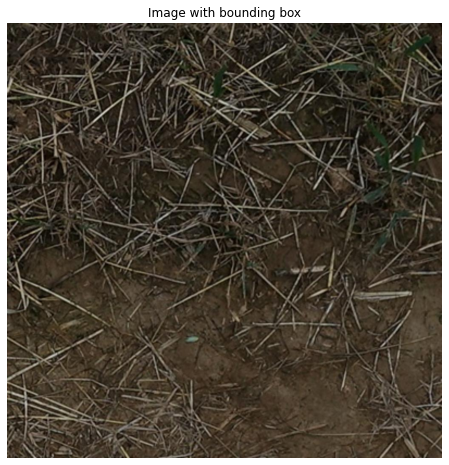

In [16]:
image_id = '8425a537b.jpg'
image_path = glob.glob(os.path.join(dir[1] , image_id))
image , boxes  = load_image_and_boxes(image_path[0])
show_image(image, boxes, "Image with bounding box")

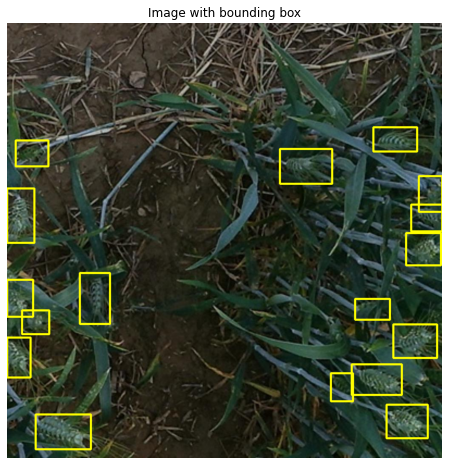

In [17]:
image_id = 'b3c96d5ad.jpg'
image_path = glob.glob(os.path.join(dir[1] , image_id))
image , boxes  = load_image_and_boxes(image_path[0])
show_image(image, boxes, "Image with bounding box")

# **Examples of some augmentations that we will use for our train** 




## **Blur**

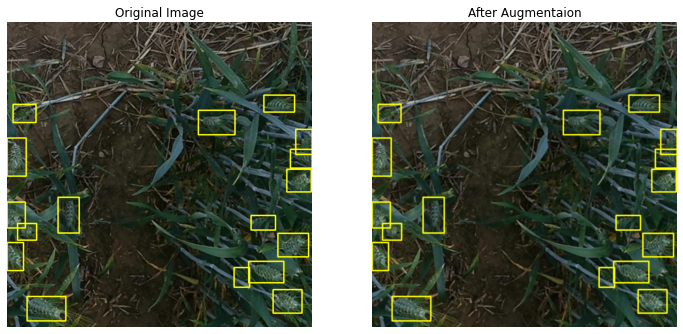

In [18]:
images_after_augmentation(image, boxes, Blur(blur_limit=7 ,p=1))

## **Vertical Flip**

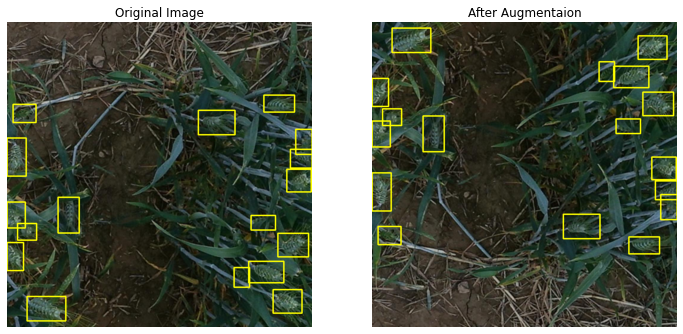

In [19]:
images_after_augmentation(image, boxes, VerticalFlip(p=1))

## **Horizontal Flip**

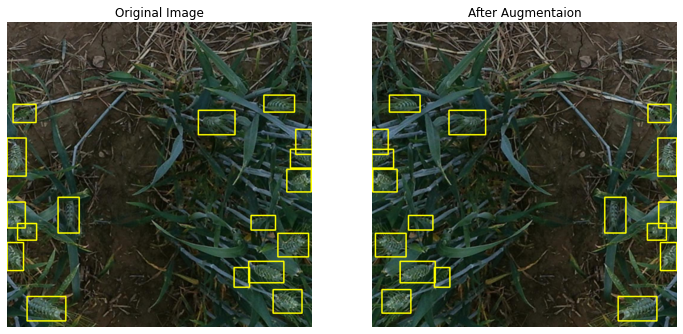

In [20]:
images_after_augmentation(image, boxes, HorizontalFlip(p=1))

# **Wheat dataset**

In [21]:
class WheatDataset(Dataset):
  def __init__(self , dataframe , image_ids,  transforms = None):
    super().__init__()
    self.image_ids = image_ids
    self.dataframe = dataframe
    self.transforms = transforms


  def __getitem__(self, index: int):
    image_id = self.image_ids[index]
    
    image, boxes = self.load_image_and_boxes(index)
    labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
 
    target = {}
    target['boxes'] = boxes
    target['labels'] = labels
    target['image_id'] = torch.tensor([index])
    
    if self.transforms:
      for i in range(10):
        sample = self.transforms(**{
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
        })
        if len(sample['bboxes']) > 0:
            image = sample['image']
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
            #target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  #yxyx: be warning
            target['labels'] = torch.stack(sample['labels'])
            break
    return image, target, image_id
              
      
  def __len__(self) -> int:
      return self.image_ids.shape[0]


  def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{dir[1]}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        records = self.dataframe[self.dataframe['image_id'] == image_id]
        boxes = records[['x', 'y', 'w', 'h']].values
        area = (boxes[:, 2] * boxes[:, 3])
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        return image, boxes

# **Augmentations**

In [22]:
transforms_train = Compose([IAASharpen(p = 0.7), RandomSizedCrop(min_max_height=(512, 512), height=1024, width=1024, p=0.5),ToGray(p=0.01),
                            OneOf([HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, val_shift_limit=0.2, p=0.9),
                                    RandomBrightnessContrast(brightness_limit=0.2,contrast_limit=0.2, p=0.9)]),
                            OneOf([Blur(blur_limit=3), MotionBlur(blur_limit=3), MedianBlur(blur_limit=3)]),
                            OneOf([VerticalFlip(), HorizontalFlip()]),
                            Cutout(num_holes=10, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
                            Resize(height=512, width=512, p = 1.0)
                            ,ToTensorV2(p=1.0),
                            ],p = 1.0,bbox_params=BboxParams(format='pascal_voc', min_area=0, 
                                               min_visibility=0, label_fields=['labels']))


transforms_valid = Compose([Resize(height=512, width=512, p=1.0),
                            ToTensorV2(p=1.0),], p=1.0,
                            bbox_params=BboxParams(
                                format='pascal_voc',
                                min_area=0,
                                min_visibility=0,
                                label_fields=['labels']))

# **Data Loader**

In [23]:
def collate_fn(batch):
  return tuple(zip(*batch))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


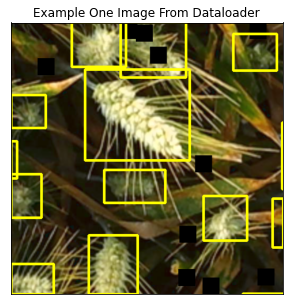

In [24]:
bs = 2
fold_number = 0

train_set = WheatDataset(dataframe=df, image_ids=df_folds[df_folds['fold'] != fold_number].index.values , transforms=transforms_train)
valid_set = WheatDataset(dataframe=df, image_ids=df_folds[df_folds['fold'] == fold_number].index.values , transforms=transforms_valid)

train_loader = DataLoader(train_set,batch_size = bs,sampler=RandomSampler(train_set),pin_memory=False,
        drop_last=True,collate_fn=collate_fn , num_workers=4)
valid_loader = DataLoader(valid_set,batch_size = bs ,sampler=SequentialSampler(valid_set),pin_memory=False,
        drop_last=True,collate_fn=collate_fn , num_workers=4)

images , targets , path_images = next(iter(train_loader))
img = visualizeTarget(images[0],targets[0])
visualize(Example_one_image_from_dataloader = img)

# **Train/Validation**

In [25]:
class Calculator(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [26]:
class Training:
    
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0

        self.base_dir = f'{config.folder}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)
        self.best_calc_loss = 10**5
        self.model = model
        self.device = device
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.lr)
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)


    def train_loop(self, train_loader, validation_loader):
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                print(f'\n{timestamp}\nLR: {lr}')
            t = time.time()
            calc_loss = self.train_one_epoch(train_loader)
            print(f'Train. Epoch: {self.epoch}, Loss: {calc_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save_model(f'{self.base_dir}/last-epoch.bin')
            t = time.time()
            calc_loss = self.valid_one_epoch(validation_loader)
            print(f'Val. Epoch: {self.epoch}, Loss: {calc_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            if calc_loss.avg < self.best_calc_loss:
                self.best_calc_loss = calc_loss.avg
                self.model.eval()
                self.save_model(f'{self.base_dir}/efficient-best-{str(self.epoch).zfill(3)}epoch.bin')
            if self.config.validation_scheduler:
                self.scheduler.step(metrics=calc_loss.avg)
            self.epoch += 1


    def train_one_epoch(self, train_loader):
      self.model.train()
      calc_loss = Calculator()
      t = time.time()
      target_res = {}
      for images, targets, image_ids in tqdm_notebook(train_loader):
        images = torch.stack(images)
        images = images.to(self.device).float()
        batch_size = images.shape[0]
        boxes = [target['boxes'].to(self.device).float() for target in targets]
        labels = [target['labels'].to(self.device).float() for target in targets]
        target_res['bbox'] = boxes
        target_res['cls'] = labels  
        self.optimizer.zero_grad()
        outputs = self.model(images, target_res)
        loss = outputs['loss']
        calc_loss.update(loss.detach().item(), batch_size)
        loss.backward()
        self.optimizer.step()
        if self.config.step_scheduler:
          self.scheduler.step()
      return calc_loss


    def valid_one_epoch(self, val_loader):
        self.model.eval()
        calc_loss = Calculator()
        t = time.time()
        with torch.no_grad():
          for images, targets, image_ids in tqdm_notebook(val_loader):
              images = torch.stack(images)
              images = images.to(self.device).float()
              batch_size = images.shape[0]
              boxes = [target['boxes'].to(self.device).float() for target in targets]
              labels = [target['labels'].to(self.device).float() for target in targets]
              target_res = {}
              target_res['bbox'] = boxes
              target_res['cls'] = labels 
              target_res["img_scale"] = torch.tensor([1.0] * batch_size, dtype=torch.float).to(self.device)
              target_res["img_size"] = torch.tensor([images[0].shape[-2:]] * batch_size, dtype=torch.float).to(self.device)
              outputs = self.model(images, target_res)
              loss = outputs['loss']
              calc_loss.update(loss.detach().item(), batch_size)
        return calc_loss



    def save_model(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_calc_loss': self.best_calc_loss,
            'epoch': self.epoch,
        }, path)


    def load_model(self, path):
        model = torch.load(path)
        self.model.model.load_state_dict(model['model_state_dict'])
        self.optimizer.load_state_dict(model['optimizer_state_dict'])
        self.scheduler.load_state_dict(model['scheduler_state_dict'])
        self.best_calc_loss = model['best_calc_loss']
        self.epoch = model['epoch'] + 1

# **EfficientDet_D7 Model**
`num_classes = 1` - only one class called wheat





In [27]:
def get_model(num_classes = 1):
  config = get_efficientdet_config('tf_efficientdet_d7x')
  model = EfficientDet(config, pretrained_backbone=False)
  checkpoint = torch.load('/content/drive/My Drive/Global Wheat Detection/efficientdet_d7x/tf_efficientdet_d7x-f390b87c.pth')
  model.load_state_dict(checkpoint)
  config.num_classes = num_classes
  config.image_size = 512
  model.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))
  return DetBenchTrain(model, config)

In [28]:
class GlobalParametersTrain:
    lr = 0.0002 
    n_epochs = 20

    folder = '/content/drive/My Drive/Global Wheat Detection/efficientdet_d7x'

    verbose = True
    verbose_step = 10

    step_scheduler = False 
    validation_scheduler = True 
    
    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(mode='min',factor=0.5,patience=1,verbose=False, threshold=0.0001,threshold_mode='abs',cooldown=0, min_lr=1e-8,eps=1e-08)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
training = Training(model=get_model().to(device), device=device, config=GlobalParametersTrain)
training.train_loop(train_loader, valid_loader)


2020-08-03T06:53:04.654603
LR: 0.0002


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Train. Epoch: 0, Loss: 1.84258, time: 1073.76251


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Val. Epoch: 0, Loss: 1.16851, time: 91.24643

2020-08-03T07:12:42.111944
LR: 0.0002



Train. Epoch: 1, Loss: 1.17473, time: 1072.72073



Val. Epoch: 1, Loss: 1.09523, time: 75.59092

2020-08-03T07:31:58.886285
LR: 0.0002



Train. Epoch: 2, Loss: 1.01053, time: 1074.94843



Val. Epoch: 2, Loss: 0.88212, time: 75.80018

2020-08-03T07:51:18.841981
LR: 0.0002



Train. Epoch: 3, Loss: 0.84797, time: 1077.57771



Val. Epoch: 3, Loss: 0.75097, time: 74.75875

2020-08-03T08:10:39.898732
LR: 0.0002



Train. Epoch: 4, Loss: 0.74538, time: 1075.03417



Val. Epoch: 4, Loss: 0.80201, time: 76.02420

2020-08-03T08:29:55.279000
LR: 0.0002



Train. Epoch: 5, Loss: 0.69960, time: 1083.76615



Val. Epoch: 5, Loss: 0.68880, time: 76.39695

2020-08-03T08:49:24.581199
LR: 0.0002



Train. Epoch: 6, Loss: 0.65823, time: 1081.65771



Val. Epoch: 6, Loss: 0.65733, time: 76.09911

2020-08-03T09:08:51.172445
LR: 0.0002



Train. Epoch: 7, Loss: 0.63163, time: 1081.34967



Val. Epoch: 7, Loss: 0.62096, time: 75.92797

2020-08-03T09:28:17.146909
LR: 0.0002



Train. Epoch: 8, Loss: 0.60916, time: 1080.84140



Val. Epoch: 8, Loss: 0.59157, time: 75.32105

2020-08-03T09:47:41.952279
LR: 0.0002



Train. Epoch: 9, Loss: 0.60639, time: 1081.73627



Val. Epoch: 9, Loss: 0.57796, time: 76.48343

2020-08-03T10:07:09.021010
LR: 0.0002



Train. Epoch: 10, Loss: 0.58083, time: 1079.78723



Val. Epoch: 10, Loss: 0.55365, time: 75.35845

2020-08-03T10:26:33.313649
LR: 0.0002


### **Load best efficientdet d7 model are trained**

In [ ]:
def load_model(checkpoint_path):
    config = get_efficientdet_config('tf_efficientdet_d7x')
    model = EfficientDet(config, pretrained_backbone=False)

    config.num_classes = 1
    config.image_size=512
    model.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))

    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])

    del checkpoint
    gc.collect()

    model = DetBenchPredict(model, config)
    model.eval();
    return model.cuda()
model = load_model('/content/drive/My Drive/Global Wheat Detection/efficientdet_d7x/efficient-best-11epoch.bin')


In [ ]:
training = Training(model=get_model().to(device), device=device, config=GlobalParametersTrain)
training.load_model('/content/drive/My Drive/Global Wheat Detection/efficientdet_d7x/efficient-best-09epoch.bin')
training.train_loop(train_loader, valid_loader)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def make_predictions(images ,  score_threshold=0.22):
    images = torch.stack(images).cuda().float()
    predictions = []
    with torch.no_grad():
        outputs = model(images , torch.tensor([1.0] * images.shape[0], dtype=torch.float).to(device) , torch.tensor([images[0].shape[-2:]] * images.shape[0], dtype=torch.float).to(device))
        for i in range(images.shape[0]):
            boxes = outputs[i].detach().cpu().numpy()[:,:4]    
            scores = outputs[i].detach().cpu().numpy()[:,4]
            labels = outputs[i].detach().cpu().numpy()[:,5]
            indexes = np.where(scores > score_threshold)[0]
            boxes = boxes[indexes]
            boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
            predictions.append({
                'boxes': boxes[indexes],
                'scores': scores[indexes],
                'labels': labels[indexes],
            })
    return [predictions]

# **Weighted Boxes Fusion**
**Why WBF can be better than NMS or SoftNMS?**

Both NMS and Soft-NMS exclude some boxes, but WBF
uses information from all boxes. It can fix some cases where
all boxes are predicted inaccurate by all models. NMS will
leave only one inaccurate box, while WBF will fix it using
information from all 3 boxes. 

See the example in Fig. 1 ,
red predictions, blue ground truth.

*Reference* : https://arxiv.org/pdf/1910.13302.pdf


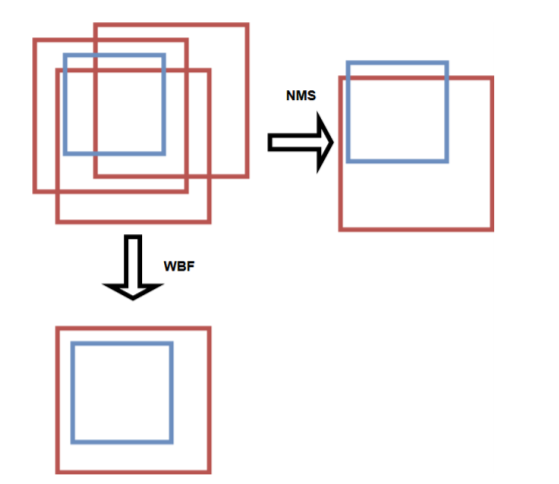

In [ ]:
def run_wbf(predictions, image_index, image_size=512, iou_thr=0.44, skip_box_thr=0.43, weights=None):
    boxes = [(prediction[image_index]['boxes']/(image_size-1)).tolist()  for prediction in predictions]
    scores = [prediction[image_index]['scores'].tolist()  for prediction in predictions]
    # labels = [np.ones(prediction[image_index]['scores'].shape[0]).tolist() for prediction in predictions]
    labels = [prediction[image_index]['labels'].tolist() for prediction in predictions]
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    boxes = boxes*(image_size-1)
    return boxes, scores, labels

In [ ]:
for j, (images, targets , image_ids) in enumerate(valid_loader):
    break
predictions = make_predictions(images)

i = 0
sample = images[i].permute(1,2,0).cpu().numpy()

boxes, scores, labels = run_wbf(predictions, image_index=i)
boxes = boxes.astype(np.int32).clip(min=0, max=511)

### **Example from validation set of ground truth vs prediction**  

In [ ]:
def show_result(sample_id, preds, gt_boxes):
    sample = cv2.imread(f'{dir[1]}/{sample_id}.jpg', cv2.IMREAD_COLOR)
    sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)

    preds = (preds*2).astype(np.int32).clip(min=0, max=1023)
    gt_boxes = (gt_boxes*2).astype(np.int32).clip(min=0, max=1023)
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for gt_box in gt_boxes:    
        cv2.rectangle(
            sample,
            (gt_box[3], gt_box[2]),
            (gt_box[1], gt_box[0]),
            (255, 255, 0), 3
        )
        
    for pred_box in preds:
        cv2.rectangle(sample,(pred_box[0], pred_box[1]),(pred_box[2], pred_box[3]),
            (255, 0, 0), 3)
    ax.set_axis_off()
    ax.imshow(sample)
    ax.set_title("RED: Predicted | YELLOW - Ground-truth")
# f5a1f0358
show_result(image_ids[0], boxes, targets[0]['boxes'].numpy())

# **TTA Classes**

In [ ]:
class BaseWheatTTA:
    """ author: @shonenkov """
    image_size = 512

    def augment(self, image):
        raise NotImplementedError
    
    def batch_augment(self, images):
        raise NotImplementedError
    
    def deaugment_boxes(self, boxes):
        raise NotImplementedError

class TTAHorizontalFlip(BaseWheatTTA):
    """ author: @shonenkov """

    def augment(self, image):
        return image.flip(1)
    
    def batch_augment(self, images):
        return images.flip(2)
    
    def deaugment_boxes(self, boxes):
        boxes[:, [1,3]] = self.image_size - boxes[:, [3,1]]
        return boxes

class TTAVerticalFlip(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return image.flip(2)
    
    def batch_augment(self, images):
        return images.flip(3)
    
    def deaugment_boxes(self, boxes):
        boxes[:, [0,2]] = self.image_size - boxes[:, [2,0]]
        return boxes
    
class TTARotate90(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return torch.rot90(image, 1, (1, 2))

    def batch_augment(self, images):
        return torch.rot90(images, 1, (2, 3))
    
    def deaugment_boxes(self, boxes):
        res_boxes = boxes.copy()
        res_boxes[:, [0,2]] = self.image_size - boxes[:, [1,3]]
        res_boxes[:, [1,3]] = boxes[:, [2,0]]
        return res_boxes

class TTACompose(BaseWheatTTA):
    """ author: @shonenkov """
    def __init__(self, transforms):
        self.transforms = transforms
        
    def augment(self, image):
        for transform in self.transforms:
            image = transform.augment(image)
        return image
    
    def batch_augment(self, images):
        for transform in self.transforms:
            images = transform.batch_augment(images)
        return images
    
    def prepare_boxes(self, boxes):
        result_boxes = boxes.copy()
        result_boxes[:,0] = np.min(boxes[:, [0,2]], axis=1)
        result_boxes[:,2] = np.max(boxes[:, [0,2]], axis=1)
        result_boxes[:,1] = np.min(boxes[:, [1,3]], axis=1)
        result_boxes[:,3] = np.max(boxes[:, [1,3]], axis=1)
        return result_boxes
    
    def deaugment_boxes(self, boxes):
        for transform in self.transforms[::-1]:
            boxes = transform.deaugment_boxes(boxes)
        return self.prepare_boxes(boxes)

# **Combinations of TTA**

In [ ]:
from itertools import product
tta_transforms = []
for tta_combination in product([TTAHorizontalFlip(), None], [TTAVerticalFlip(), None],[TTARotate90(), None]):
    tta_transforms.append(TTACompose([tta_transform for tta_transform in tta_combination if tta_transform]))

In [ ]:
def make_tta_predictions(images, score_threshold=0.5):
    with torch.no_grad():
        images = torch.stack(images).float().cuda()
        predictions = []
        for tta_transform in tta_transforms:
            result = []
            outputs = model(tta_transform.batch_augment(images.clone()), torch.tensor([1]*images.shape[0]).float().cuda() ,  torch.tensor([images[0].shape[-2:]] * images.shape[0], dtype=torch.float).to(device))

            for i in range(images.shape[0]):
                boxes = outputs[i].detach().cpu().numpy()[:,:4]    
                scores = outputs[i].detach().cpu().numpy()[:,4]
                labels = outputs[i].detach().cpu().numpy()[:,5]
                indexes = np.where(scores > score_threshold)[0]
                boxes = boxes[indexes]
                boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
                boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
                boxes = tta_transform.deaugment_boxes(boxes.copy())
                result.append({
                    'boxes': boxes,
                    'scores': scores[indexes],
                    'labels': labels[indexes],
                })
            predictions.append(result)
    return predictions

In [ ]:
for j, (images, targets , image_ids) in enumerate(valid_loader):
    break


predictions = make_tta_predictions(images)

i = 0
sample = images[i].permute(1,2,0).cpu().numpy()

boxes, scores, labels = run_wbf(predictions, image_index=i)
boxes = boxes.astype(np.int32).clip(min=0, max=511)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (1, 1, 0), 2)
    
ax.set_axis_off()
ax.imshow(sample);

# **Examples with TTA  - Test time augmentation**

In [ ]:
# def display_tta(path):
#     iou_thr = 0.4
#     detection_threshold = 0.5
#     model.cuda()
#     model.eval()

#     img = plt.imread(path).astype(np.float32)
#     img /= 255.0
    
#     t = Compose([Resize(width=512,height=512),ToTensorV2()])
#     data = { "image": img}
#     data = t(**data)
    
#     img_tensor = data["image"]
#     img_tensor = img_tensor.squeeze(0)
#     selected_tta = random.choice(tta_transforms)
    
#     tta_image = selected_tta.augment(img_tensor)
#     outputs = model(tta_image.unsqueeze(0).cuda())
#     boxes = outputs[0]['boxes'].data.detach().cpu().numpy()
#     scores = outputs[0]['scores'].data.detach().cpu().numpy() 
    
#     boxes = boxes[scores >= detection_threshold]
#     scores = scores[scores >= detection_threshold]
#     original_boxes  = selected_tta.deaugment_boxes(boxes.copy())
    
#     img_tta = tta_image.permute(1,2,0).detach().cpu().numpy()
#     img = img_tensor.permute(1,2,0).detach().cpu().numpy()

#     return img , img_tta , boxes , original_boxes

In [ ]:
# for image_path in test_paths:
#     img , tta_img , boxes , original_boxes = display_tta(image_path)
#     original_with_boxes = visualizeTarget(img,{"boxes": original_boxes},visualize_data_loader = False)
#     tta_with_boxes = visualizeTarget(tta_img,{"boxes": boxes},visualize_data_loader = False)
#     visualize(input_image = img, image_with_tta_bounding_boxes = tta_with_boxes , original_with_bounding_boxes = original_with_boxes)

# **Inference**

In [ ]:
test_transforms =  Compose([
            Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)

In [ ]:
class TestDataset(Dataset):

    def __init__(self, image_ids, transforms=None):
        super().__init__()
        self.image_ids = image_ids
        self.transforms = transforms

    def __getitem__(self, index):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{dir[2]}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        if self.transforms:
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']
        return image, image_id

    def __len__(self):
        return self.image_ids.shape[0]

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
test_set = TestDataset(image_ids=np.array([path.split('/')[-1][:-4] for path in test_paths]),transforms=test_transforms)
test_loader = DataLoader(test_set,batch_size=4,shuffle=False,num_workers=2,drop_last=False,collate_fn=collate_fn)

In [ ]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))
    return " ".join(pred_strings)

In [ ]:
submission = []

for images, image_ids in test_loader:
    predictions = make_tta_predictions(images)
    for i, image in enumerate(images):
        boxes, scores, labels = run_wbf(predictions, image_index=i)
        img = visualizeTarget(image, {'boxes' : boxes} , visualize_data_loader = True)
        visualize(test_image = img)
        
        boxes = (boxes*2).astype(np.int32).clip(min=0, max=1023)
        image_id = image_ids[i]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }
        submission.append(result)

# **Submission**

In [ ]:
SUBMISSION_PATH = '/content/drive/My Drive/Global Wheat Detection/efficientdet_d7x/submission'
submission_id = 'submission'
submission_path = os.path.join(SUBMISSION_PATH, '{}.csv'.format(submission_id))
sample_submission = pd.DataFrame(submission, columns=["image_id","PredictionString"])
sample_submission.to_csv(submission_path, index=False)
submission_df = pd.read_csv(submission_path)
submission_df